<a href="https://colab.research.google.com/github/JayThibs/Machine-Learning-With-Tabular-Data/blob/master/Rossman_Store_Sales_Tabular_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rossmann Store Sales

## Description

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

## Problem Statement

Our goal is to be able to predict the number of sales for a particular date and store.

In [0]:
%reload_ext autoreload
%autoreload 2

In [2]:
!pip install http://download.pytorch.org/whl/cpu/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip install fastai

# !pip install fastai==0.7.0
# !pip install torchtext==0.2.3

     |████████████████████████████████| 69.4MB 10.8MB/s 
ERROR: torchvision 0.4.0 has requirement torch==1.2.0, but you'll have torch 1.0.0 which is incompatible.
  Found existing installation: torch 1.2.0
    Uninstalling torch-1.2.0:
      Successfully uninstalled torch-1.2.0


In [0]:
from fastai import *
from fastai.tabular import *
from fastai.basics import *
import os # for reading from the file

## Data Preparation / Feature Engineering

We will be using [external data](http://files.fast.ai/part2/lesson14/rossmann.tgz) along with the data provided in the Kaggle competition.

In [4]:
!wget -P /content/ http://files.fast.ai/part2/lesson14/rossmann.tgz

--2019-10-15 20:08:31--  http://files.fast.ai/part2/lesson14/rossmann.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7730448 (7.4M) [application/x-gtar-compressed]
Saving to: ‘/content/rossmann.tgz’

rossmann.tgz        100%[===================>]   7.37M  4.38MB/s    in 1.7s    

2019-10-15 20:08:33 (4.38 MB/s) - ‘/content/rossmann.tgz’ saved [7730448/7730448]



In [0]:
!tar -xf /content/rossmann.tgz

In [0]:
!rm -rf /content/rossmann.tgz

In [7]:
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend',
               'weather', 'test']

tables = [pd.read_csv(f'{fname}.csv', low_memory=False) \
          for fname in table_names]
train, store, store_states, state_names, googletrend, weather, test = tables
len(train), len(test) # number of train and test examples

(1017209, 41088)


The data we will be using:

*   train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
*   store: general info about the store including competition, etc.
*   store_states: maps store to state it is in
*   state_names: Maps state abbreviations to names
*   googletrend: trend data for particular week/state
*   weather: weather conditions for each state
*   test: Same as training table, w/o sales and customers

Let's have a look at what our training set looks like:

In [8]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
train.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


Let's have a look at all the datasets:

In [10]:
from IPython.display import HTML, display
for t in tables: display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,65,1013,1005,1001,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,78,1028,1022,1014,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,77,1035,1030,1026,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,87,1036,1035,1034,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,87,1035,1034,1033,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


And now we can summarize the datasets:

In [11]:
for t in tables: display(t.describe())

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


,Store
count,1115.00000
mean,558.00000
std,322.01708
min,1.00000
25%,279.50000
50%,558.00000
75%,836.50000
max,1115.00000


,StateName,State
count,16,16
unique,16,16
top,NordrheinWestfalen,HH
freq,1,1


,trend
count,2072.000000
mean,63.814189
std,12.650246
min,0.000000
25%,55.000000
50%,64.000000
75%,72.000000
max,100.000000


,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,WindDirDegrees
count,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15459.000000,15459.000000,15459.000000,15840.000000,15840.000000,3604.000000,15840.000000,14667.000000,15840.000000
mean,14.644129,10.388952,6.198990,8.587816,6.205808,3.626136,93.659596,74.282891,50.158586,1018.532197,1015.299747,1012.307955,24.057572,12.239796,7.025163,22.766604,11.972222,48.864317,0.831718,5.551306,175.896717
std,8.646012,7.379260,6.526391,6.244780,6.086768,6.128390,7.678530,13.486552,19.960216,7.788720,8.123311,8.600585,8.976799,5.067944,4.980602,8.988618,5.872844,13.026954,2.513506,1.687710,101.588872
min,-11.000000,-13.000000,-15.000000,-14.000000,-15.000000,-73.000000,44.000000,30.000000,4.000000,976.000000,974.000000,970.000000,0.000000,0.000000,0.000000,3.000000,2.000000,21.000000,0.000000,0.000000,-1.000000
25%,8.000000,4.000000,1.000000,4.000000,2.000000,-1.000000,90.750000,65.000000,34.000000,1014.000000,1010.000000,1007.000000,14.000000,10.000000,3.000000,16.000000,8.000000,39.000000,0.000000,5.000000,80.000000
50%,15.000000,11.000000,7.000000,9.000000,7.000000,4.000000,94.000000,76.000000,49.000000,1019.000000,1016.000000,1013.000000,31.000000,11.000000,7.000000,21.000000,11.000000,48.000000,0.000000,6.000000,202.000000
75%,21.000000,16.000000,11.000000,13.000000,11.000000,8.000000,100.000000,85.000000,66.000000,1024.000000,1021.000000,1018.000000,31.000000,14.000000,10.000000,27.000000,14.000000,55.000000,0.250000,7.000000,256.000000
max,39.000000,31.000000,24.000000,25.000000,20.000000,19.000000,100.000000,100.000000,100.000000,1043.000000,1040.000000,1038.000000,31.000000,31.000000,31.000000,101.000000,53.000000,111.000000,58.930000,8.000000,360.000000


,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


If we look at `StateHoliday`, we have 0 and a as values. There are actually four types of values: a = public holiday, b = Easter holiday, c = Christmas, and 0 = None. We'll be turning it into a boolean in order to make it more convenient for modeling.

In [0]:
train.StateHoliday = train.StateHoliday != '0'
test.StateHoliday = test.StateHoliday != '0'

In [13]:
train.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,False,1


In [14]:
train.tail(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017208,1115,2,2013-01-01,0,0,0,0,True,1


Since we have a DataFrames, we're going to join them together. We can start by creating a function called `join_df` that will join tables on specific fields:

In [0]:
# The suffix argument '_y' appends all the duplicate field names.
# We will drop these duplicate columns later.
def join_df(left, right, left_on, right_on=None, suffix='_y'):
  if right_on is None: right_on = left_on
  return left.merge(right, how='left', left_on=left_on, right_on=right_on,
                    suffixes=("", suffix))

Let's join the weather/state names.

In [0]:
weather = join_df(weather, state_names, "file", "StateName")

In [17]:
weather.head()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,State
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,65,1013,1005,1001,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,NW
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,78,1028,1022,1014,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225,NordrheinWestfalen,NW
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,77,1035,1030,1026,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240,NordrheinWestfalen,NW
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,87,1036,1035,1034,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263,NordrheinWestfalen,NW
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,87,1035,1034,1033,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268,NordrheinWestfalen,NW


To capture the trend and cyclical behavior as a function of time, we will be using `googletrend` and add new columns based on the week column so that we have extra granularity.

We'll also change the statename 'NI' with 'HB,NI' to make it match the rest of our data.

In [18]:
googletrend.head()

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


In [0]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

In [20]:
googletrend.head()

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN


In [0]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [0]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

The `googletrend` data has a special category for the whole of Germany, so we'll filter everything else out.

In [0]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

We can now outer join all of our data into a single dataframe.

Outer Join is often easier (better) than inner join. We just need to check if there are any null values after we've joined the tables. This avoids any mistakes we might make. For example, if some of the data between tables is not the same, we will get null values. It's worth it to check this before moving forward.

In [0]:
store = join_df(store, store_states, "Store")

In [25]:
len(store[store.State.isnull()])

0

No null values. Now let's join the rest of our dataframes.

In [26]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [27]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [28]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [29]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [30]:
joined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,Date_y,Month_y,Day_y,Dayofweek_y,Dayofyear_y,...,Is_year_end_DE,Is_year_start_DE,Elapsed_DE,file_y,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,Year_y,Month_y,Week_y,Day_y,Dayofweek_y,Dayofyear_y,Is_month_end_y,Is_month_start_y,Is_quarter_end_y,Is_quarter_start_y,Is_year_end_y,Is_year_start_y,Elapsed_y
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,HE,Rossmann_DE_HE,2015-08-02 - 2015-08-08,85,2015-08-02,8,2,6,214,...,False,False,1438473600,Hessen,23,16,8,9,6,3,98,54,18,1021,1018,1015,31.0,15.0,10.0,24,11,NaN,0.0,1.0,Fog,13,Hessen,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH,Rossmann_DE_TH,2015-08-02 - 2015-08-08,80,2015-08-02,8,2,6,214,...,False,False,1438473600,Thueringen,19,13,7,9,6,3,100,62,25,1021,1019,1017,10.0,10.0,10.0,14,11,NaN,0.0,4.0,Fog,309,Thueringen,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NW,Rossmann_DE_NW,2015-08-02 - 2015-08-08,86,2015-08-02,8,2,6,214,...,False,False,1438473600,NordrheinWestfalen,21,13,6,10,7,4,100,61,24,1022,1019,1017,31.0,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354,NordrheinWestfalen,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,BE,Rossmann_DE_BE,2015-08-02 - 2015-08-08,74,2015-08-02,8,2,6,214,...,False,False,1438473600,Berlin,19,14,9,9,7,4,94,61,30,1019,1017,1014,10.0,10.0,10.0,23,16,NaN,0.0,6.0,NaN,282,Berlin,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,SN,Rossmann_DE_SN,2015-08-02 - 2015-08-08,82,2015-08-02,8,2,6,214,...,False,False,1438473600,Sachsen,20,15,10,8,6,5,82,55,26,1020,1018,1016,10.0,10.0,10.0,14,11,NaN,0.0,4.0,NaN,290,Sachsen,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800


We can now drop all rows with the _y suffix.

In [0]:
for df in (joined, joined_test):
  for c in df.columns:
    if c.endswith('_y'):
      if c in df.columns: df.drop(c, inplace=True, axis=1)

An issues that comes up often enough is missing values. Many models have problems when missing values are present. Therefore, we will be replacing these missing values with an arbitrary signal value that doesn't other appear in the data. In other words, our missing values come from the date columns so we will give the missing values a date in the year 1900.

In [0]:
for df in (joined, joined_test):
  df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
  df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
  df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
  df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

In [0]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [0]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [35]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

In [36]:
!pip install isoweek
from isoweek import Week

In [0]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [0]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [0]:
joined.to_pickle('/content/joined')
joined_test.to_pickle('/content/joined_test')

## Durations

To squeeze a little bit more out of our time series dataset, we can do the following:

*   Running Averages
*   Time until next event
*   Time since last event

This is important because we are giving our model a chance to take into the effect caused by the duration between two events.

For example, in our case, our model may learn that if two sales happen within 10 days of each other, we see less of a profit than if we waited 30 days.

In our to count the time between events, we (obviously) need to take into account the time data. The time data is represented as a function of each new row.

Our function will be used to create a new set of rows that count the number of days that has elapsed between two events. Theoretically, the events could be sales, state holidays, school closures, etc.

We'll define the function `get_elapsed` and give it a particular field `fld` to monitor the time elapsed since the last event. The counter will restart every time a new event comes along.



In [0]:
def get_elapsed(fld, pre):
  day1 = np.timedelta64(1, 'D')
  last_date = np.datetime64()
  last_store = 0
  res = []

  for s, v, d in zip(df.Store.values, df[fld].values, df.Date.values):
    if s != last_store:
      last_date = np.datetime64()
      last_store = s
    if v: last_date = d
    res.append(((d-last_date).astype('timedelta64[D]')/day1))
  df[pre+fld] = res

We'll be applying `get_elapsed` to the following columns:

In [0]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [0]:
df = train[columns].append(test[columns])

In [0]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We're going to set the active index to Date:

In [0]:
df = df.set_index('Date')

In [47]:
df.head()

,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo
Date,,,,,,,,,,
2015-09-17,1,1,False,0,13.0,NaN,105.0,NaN,0.0,0.0
2015-09-16,1,1,False,0,12.0,NaN,104.0,NaN,0.0,0.0
2015-09-15,1,1,False,0,11.0,NaN,103.0,NaN,0.0,0.0
2015-09-14,1,1,False,0,10.0,NaN,102.0,NaN,0.0,0.0
2015-09-13,1,0,False,0,9.0,NaN,101.0,NaN,9.0,-1.0


In [48]:
len(df.isnull())

1058297

We can see that there are null values in our dataframe. Our function gives us null values, we need to replace them with 0.

In [0]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [0]:
for o in ['Before', 'After']:
  for p in columns:
    a = o+p
    df[a] = df[a].fillna(0).astype(int)

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date `(sort_index())` and counting the number of events of interest `(sum())` defined in columns in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [0]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [0]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [0]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [0]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [0]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [0]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [0]:
df.drop(columns,1,inplace=True)

In [58]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [0]:
df.to_pickle('/content/df')

In [0]:
df["Date"] = pd.to_datetime(df.Date)

In [61]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [0]:
joined = pd.read_pickle('/content/joined')
joined_test = pd.read_pickle('/content/joined_test')

In [0]:
joined = join_df(joined, df, ['Store', 'Date'])

In [0]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

The original authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the (Kaggle) competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [0]:
joined = joined[joined.Sales!=0]

In [0]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [0]:
joined.to_pickle('/content/train_clean')
joined_test.to_pickle('/content/test_clean')

In [68]:
!zip -r /content/rossmann_dataframe.zip /content/

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2019.08.27/ (stored 0%)
  adding: content/.config/logs/2019.08.27/16.17.21.663235.log (deflated 54%)
  adding: content/.config/logs/2019.08.27/16.17.22.686467.log (deflated 55%)
  adding: content/.config/logs/2019.08.27/16.17.07.367707.log (deflated 54%)
  adding: content/.config/logs/2019.08.27/16.17.00.530950.log (deflated 90%)
  adding: content/.config/logs/2019.08.27/16.17.17.407104.log (deflated 85%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (stored 0%)
  adding: content/.config/.metricsUUID (stored 0%)
  adding: content/store.csv (deflated 79%)
  adding: content

# Data Preparation

In [69]:
train_df = pd.read_pickle('train_clean')
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [70]:
n = len(train_df)
n

844338

## Experimenting with a sample of the dataset

We'll start off by experimenting with a subset of our dataset in order to test some preprocessing quickly.

In [0]:
idx = np.random.permutation(range(n))[:2000]  # take a random 2000 element subset
idx.sort() # sort numbers in ascending order
small_train_df = train_df.iloc[idx[:1000]] # create a 1000 element train set (the first 1000)
small_test_df = train_df.iloc[idx[1000:]] # create a 1000 element test set (the final 1000)
small_cont_vars = ["CompetitionDistance", "Mean_Humidity"] 
small_cat_vars = ["Store", "DayOfWeek", "PromoInterval"]
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ["Sales"]]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ["Sales"]]

In [72]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
259,260,5,NaN,540.0,61,6849
546,548,5,NaN,3760.0,54,5101
646,648,5,NaN,2130.0,61,7947
782,784,5,"Jan,Apr,Jul,Oct",560.0,61,9284
983,986,5,"Feb,May,Aug,Nov",620.0,61,7051


In [73]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
433819,746,3,"Mar,Jun,Sept,Dec",4330.0,63,5579
434114,1041,3,"Jan,Apr,Jul,Oct",1600.0,56,5524
434160,1088,3,"Jan,Apr,Jul,Oct",4300.0,67,5433
434706,521,2,"Mar,Jun,Sept,Dec",18610.0,70,5577
435585,288,1,"Mar,Jun,Sept,Dec",800.0,66,7765


As we can see in the column "PromoInterval", there are some months in some of the rows, but some of the rows have NaN values. These values are missing from the dataset. Let's use `Categorify` to convert each variable in this column into a category.

In [0]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True) # True makes sure that it uses the same categories as the train set

In [75]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
433819,746,3,"Mar,Jun,Sept,Dec",4330.0,63,5579
434114,NaN,3,"Jan,Apr,Jul,Oct",1600.0,56,5524
434160,NaN,3,"Jan,Apr,Jul,Oct",4300.0,67,5433
434706,521,2,"Mar,Jun,Sept,Dec",18610.0,70,5577
435585,NaN,1,"Mar,Jun,Sept,Dec",800.0,66,7765


As we can see, it still displays the same values, but that is only on the outside. If we look on the inside, we can see that the values are actually categorized.

In [76]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

We can see all the categories/classes.

In [77]:
small_train_df["PromoInterval"].cat.codes[:100]

259     -1
546     -1
646     -1
782      1
983      0
1223     1
1228    -1
1772    -1
2272     1
2515    -1
2752     1
2806    -1
2821     2
3392     0
3419     1
4079    -1
4242    -1
4624    -1
5080    -1
5403     1
5640    -1
6170     1
6831    -1
7103    -1
7704     1
7712    -1
8247    -1
8276    -1
10535   -1
11435    1
        ..
27934   -1
27984   -1
28201    0
28238    2
28481   -1
28500    1
29339   -1
29801   -1
29852   -1
30060   -1
30080   -1
30178    1
31193    0
31925    1
32099    1
32638   -1
32718   -1
33478   -1
33946   -1
33967   -1
34217    0
34224    1
35054   -1
35122   -1
35461   -1
36228   -1
36567    1
37350   -1
37601    1
38551   -1
Length: 100, dtype: int8

The -1 values are for the NaN values. We will need to add 1 to all values (to make them equal to 0) in order to create our embedding matrix later on.

The 0s, 1s, and 2s are for the other classes.

When you have a dataset with missing values, you shouldn't fret. That information is actually very important in building an accurate model. You need to the function `FillMissing`, this will create a new "_na" column based on the columns you are looking at and it will give the statement `True` if there's a missing value in that column (False if not). The fact that the value is missing is interesting and helps you predict the outcome. Keeping that information in a new column will help our depp learning model to better predict.

In [0]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

For continuous variables, like `CompetitionDistance`, we can simply compute the median and replace the missing value by that. That said, we can replace it by almost any number because if it turns out that _na is important, the model will pick this up.

In [79]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
92089,879,4,"Feb,May,Aug,Nov",2330.0,67,3447,True


## Preparing full data set

We're now going to prepare the full dataset.

In [0]:
train_df = pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/rossmann_files/train_clean')
test_df = pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/rossmann_files/test_clean')

In [16]:
len(train_df), len(test_df)

(844338, 41088)

Instead of preprocessing separately the dataset like we just did with the subset of our dataset, we can simply use include all of our preprocessing processes in the `TabularList.from_df()` function.

In [0]:
procs = [FillMissing, Categorify, Normalize] # Normalize substracts the mean and divides by std.

We have to create an array for all the categorical variables and another one for the continuous variables before we pass it in `TabularList.from_df()`.

In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

Notice in `cat_vars` that we have variables like 'Day' and 'Month' because we hypothesize that the difference between the 1st of the month, the 15th of the month, and the 30th of the month will not show a nice smooth curve. We're expecting that each of those days will show different purchasing behaviour to other days of the month. Therefore, if we make these variables categorical, it will create an embedding matrix so that different days of the month can get different behaviours.

This means that this step of deciding whether something is categorical or continuous is very important and we really need to think carefully when decide what type of variable we are looking to create.

When in doubt, if there aren't too many categories in your variable (cardinality is low), then it's best to place it as a categorical variable.

Our dependant variable:

In [0]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var, 'Date']].copy()

In [20]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

Let's create a validation set with the same number of records as the test set, but make sure that the validation set is part of final portion dataframe for training.

In [21]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [0]:
valid_idx = range(cut)

When using fastai, it will automatically assume that you want to do a classification if your dependant variable contains integers. Therefore, we need to include the paramater `label_cls=FloatList` in `TabularList` in order to tell fastai that we want to use floats and, in other words, predict a regression.

In [23]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [0]:
data = (TabularList.from_df(df, path='/content/', cat_names=cat_vars,
                           cont_names=cont_vars, procs=procs,)
                    .split_by_idx(valid_idx)
                    .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                    .add_test(TabularList.from_df(test_df, path='/content/',
                                                  cat_names=cat_vars,
                                                  cont_names=cont_vars))
                    .databunch())

We also make sure that `log=True` in order to calculate the logarithm of our dependant variable. This is simply to make our loss function the root mean squared percentage error.

In our case, we want to use the logarithm because anytime you are trying to predict something like a population or a dollar amount of sales. These things tend to have to long-tail distributions so you care more about the percentage differences than absolute/exact differences. So it's much better to use the logarithms and measure the root mean squared percentage error.

In [90]:
doc(FloatList)

class FloatList(ItemList):


    def __init__(self, items:Iterator, log:bool=False, classes:Collection=None, **kwargs):
        super().__init__(np.array(items, dtype=np.float32), **kwargs)
        self.log = log
        self.copy_new.append('log')
        self.c = self.items.shape[1] if len(self.items.shape) > 1 else 1
        self.loss_func = MSELossFlat()

    def get(self, i):
        o = super().get(i)
        return FloatItem(np.log(o) if self.log else o)

    def reconstruct(self,t): return FloatItem(t.numpy())

## Model

We'll start by creating the range for the sigmoid activation at the end of our neural network. In order to decrease training time, we prepare a range of values to give the sigmoid in advance instead of having our neural network scale it by itself during training. We take the range of `Sales` values multiplied by a number slightly higher than 1 (1.2, in our case) because we don't want the asymptote to be the highest value of sales, we want it to be slightly higher. Otherwise our model will gain some slight errors when sales are close to the highest value.

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001, 0.01], 
                        emb_drop=0.04, y_range=y_range, metrics=exp_rmspe)

In [27]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [28]:
len(data.train_ds.cont_names)

16

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


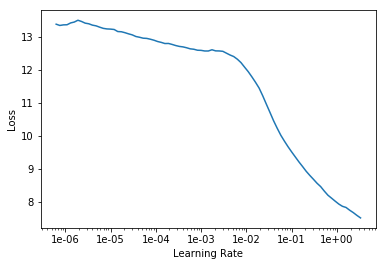

In [30]:
learn.recorder.plot()

Comparing with the fast.ai notebook on this problem, it seems that something is wrong with lr_find() since it is not displaying the plot correctly. For now, I'm going to use use the learning rate used in the course. I've tried using a learning rate of 2e-02 (which is reasonable based on the plot), but it gave a higher error than simply using the one used in the kaggle competition / in the course. For now, I'm going to assume something is wrong with lr_find() because when I use 1e-03, I get a very similar error to what was found in the course.

In [31]:
import fastai; fastai.__version__

'1.0.58'

In [98]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.022591,0.021378,0.150903,07:51
1,0.019541,0.024947,0.141562,08:46
2,0.014816,0.015570,0.117367,12:16
3,0.014208,0.017003,0.119232,16:38
4,0.011713,0.011632,0.103049,20:30


In [0]:
learn.save('model_1')

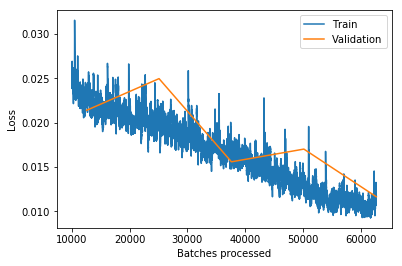

In [100]:
learn.recorder.plot_losses(skip_start=10000)

In [103]:
!zip -r /content/rossmann_model_data.zip /content/
from google.colab import files
files.download("/content/rossmann_model_data.zip")

KeyboardInterrupt: ignored

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
learn.load('/content/gdrive/My Drive/Colab Notebooks/rossmann_files/models/model_1');

In [34]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.011085,0.012337,0.114418,03:54
1,0.011869,0.013800,0.112920,03:57
2,0.010368,0.015721,0.120560,03:53
3,0.009440,0.014939,0.112009,03:52
4,0.009537,0.015666,0.113930,03:54


In [37]:
from fastai.callbacks import *
learn.fit_one_cycle(cyc_len=10, max_lr=3e-4, callbacks=[SaveModelCallback(learn,monitor='exp_rmspe',mode='min')])

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.010735,0.013074,0.109647,03:54
1,0.011377,0.015908,0.129641,03:50
2,0.010650,0.015485,0.130885,03:57
3,0.010500,0.016538,0.111814,03:59
4,0.010633,0.028858,0.111506,03:59
5,0.012651,0.016554,0.117384,03:58
6,0.008973,0.021149,0.126382,03:56
7,0.009317,0.023902,0.127143,04:01
8,0.008900,0.025132,0.127701,03:57
9,0.008413,0.020197,0.132582,03:54


Better model found at epoch 0 with exp_rmspe value: 0.10964666306972504.


In [0]:
test_preds = learn.get_preds(DatasetType.Test)
test_df["Sales"] = np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id", "Sales"]] = test_df[["Id", "Sales"]].astype("int")
test_df[["Id", "Sales"]].to_csv("rossmann_submission.csv", index=False)

In [0]:
from google.colab import files
files.download("/content/rossmann_submission.csv")
files.download("/content/models/bestmodel.pth")
files.download("/content/models/tmp.pth")

In [0]:
learn.load('/content/models/bestmodel');